In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic Text Classification

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2023-02-13 14:19:31.000896: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 14:19:31.003610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 14:19:31.003617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download and Explore the IMDB Dataset

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                 untar=True, cache_dir='.',
                                 cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [5]:
os.listdir(dataset_dir)

['imdbEr.txt', 'README', 'train', 'imdb.vocab', 'test']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'pos',
 'urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'unsup']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [7]:
sample = os.path.join(train_dir, 'pos/11111_9.txt')
with open(sample) as f:
    print(f.read())

The Sopranos is perhaps the most mind-opening series you could possibly ever want to watch. It's smart, it's quirky, it's funny - and it carries the mafia genre so well that most people can't resist watching. The best aspect of this show is the overwhelming realism of the characters, set in the subterranean world of the New York crime families. For most of the time, you really don't know whether the wise guys will stab someone in the back, or buy them lunch. <br /><br />Further adding to the realistic approach of the characters in this show is the depth of their personalities - These are dangerous men, most of them murderers, but by God if you don't love them too. I've laughed at their wisecracks, been torn when they've made err in judgement, and felt scared at the sheer ruthlessness of a serious criminal. <br /><br />The suburban setting of New Jersey is absolutely perfect for this show's subtext - people aren't always as they seem, and the stark contrast between humdrum and the actio

## Load dataset

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, we will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, we will remove them before using this utility.

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, we will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide our dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                 batch_size=batch_size,
                                                                 validation_split=0.2,
                                                                 seed=seed,
                                                                 subset='training')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2023-02-13 14:19:40.328978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-13 14:19:40.328993: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-13 14:19:40.329004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2023-02-13 14:19:40.329178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Print a few examples

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review: ', text_batch.numpy()[i])
        print("Label ", label_batch.numpy()[i])

Review:  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label  0
Review:  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get 

The labels are `0` or `1`. To see which of these correspond to `positive` and `negative` movie reviews, we can check the `class_name`s property on the dataset.

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


When using the `validation_split` and subset arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset='validation',
                                                               seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare data for training

`Standardization` refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. `Tokenization` refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). `Vectorization` refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

Next, we will create a `TextVectorization` layer. we will use this layer to standardize, tokenize, and vectorize our data. we set the `output_mode` to `int` to create unique integer indices for each token.

we're using the default split function, and the custom standardization function we defined above. we'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize=custom_standardization,
                                   max_tokens=max_features,
                                   output_mode='int',
                                   output_sequence_length=sequence_length)

Next, we will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

It's important to only use our training data when calling adapt (using the test set would leak information).

In [16]:
# Make a text only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
# Retrieve a batch ( of 32 reviews and labels) from dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label ", raw_train_ds.class_names[first_label])
print("Vectorized review: ", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label  neg
Vectorized review:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
  

Each token has been replaced by an integer

In [19]:
print("141 --->", vectorize_layer.get_vocabulary()[141])
print("4 --->", vectorize_layer.get_vocabulary()[4])
print("625 --->", vectorize_layer.get_vocabulary()[625])
print("2083 --->", vectorize_layer.get_vocabulary()[2083])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

141 ---> im
4 ---> a
625 ---> huge
2083 ---> steven
Vocabulary size: 10000


Apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training our model. If your dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 


In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create model

In [22]:
embedding_dim = 16

In [23]:
model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

## Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use `losses.BinaryCrossentropy` loss function.

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train

In [25]:
epochs = 10
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6654 - binary_accuracy: 0.6912 - val_loss: 0.6166 - val_binary_accuracy: 0.7696
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5496 - binary_accuracy: 0.7989 - val_loss: 0.4993 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4455 - binary_accuracy: 0.8439 - val_loss: 0.4206 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3786 - binary_accuracy: 0.8648 - val_loss: 0.3741 - val_binary_accuracy: 0.8622
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3356 - binary_accuracy: 0.8781 - val_loss: 0.3453 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3060 - binary_accuracy: 0.8887 - val_loss: 0.3263 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

## Evaluate

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 879us/step - loss: 0.3110 - binary_accuracy: 0.8718
Loss:  0.311021625995636
Accuracy:  0.8718000054359436


## Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

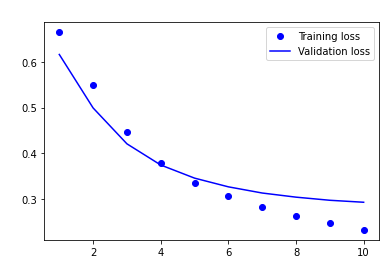

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss', color='w')
plt.xlabel('Epochs', color='w')
plt.ylabel('Loss', color='w')
plt.legend()

plt.show()

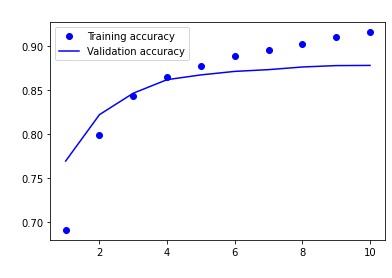

In [29]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy', color='w')
plt.xlabel('Epochs', color='w')
plt.ylabel('Accuracy', color='w')
plt.legend()

plt.show()

##### We could prevent `overfitting` by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the EarlyStopping callback.

## Export model

In the code above, we applied the TextVectorization layer to the dataset before feeding text to the model. If we want to make your model capable of processing raw strings (for example, to simplify deploying it), we can include the TextVectorization layer inside our model. To do so, we can create a new model using the weights we just trained.

In [30]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                    optimizer='adam', metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)

 73/782 [=>............................] - ETA: 0s - loss: 0.3072 - accuracy: 0.8793

/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 1s 1ms/step - loss: 0.3110 - accuracy: 0.8718


## Inference on new data


In [34]:
examples = [
    "The movie sucked",
    "I could do something else rather than watching this",
    "Too much cringe dialogues like the tamil ones",
    "Was worth the wait",
    "Not that bad I gueass",
    "Hindi dub always ruins a good movie"
]

export_model.predict(examples)

1/1 [==============================] - 0s 19ms/step


array([[0.43436933],
       [0.3479554 ],
       [0.42445222],
       [0.5120924 ],
       [0.34311822],
       [0.5849615 ]], dtype=float32)